Steel demand

In [30]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy.optimize import curve_fit

Load data

In [31]:
# Load data for steel production

def load_all_files():
    base_path = Path.cwd().parent
    historic_folder = base_path / "data" / "raw" / "steel"
    
    dfs = []
    
    for file in historic_folder.glob("*.xlsx"):
        df = pd.read_excel(file)
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

steel_data = load_all_files()

Look at data

In [32]:
# Look at the data
print(steel_data.head())

   Year   Population  Steel  Steel per capita (t)
0  1950  2471424.002  189.0              76.47413
1  1951  2514761.693    NaN                   NaN
2  1952  2559092.377    NaN                   NaN
3  1953  2609080.302    NaN                   NaN
4  1954  2659132.169    NaN                   NaN


Clean data

In [ ]:
# Replace NaN values with 0
#steel_data.fillna(0, inplace=True)

Steel per capita regression

In [34]:
# Define logistic regression function
def logistic(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0  

In [35]:
# Find steel per capita
steel_clean["Steel per capita"] = steel_clean["Steel"] * 1000000 / steel_clean["Population"]

# Define x and y for curve fitting
x_data = steel_clean["Year"].values
y_data = steel_clean["Steel per capita"].values

C:\Users\idapo\AppData\Local\Temp\ipykernel_17352\1348744049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steel_clean["Steel per capita"] = steel_clean["Steel"] * 1000000 / steel_clean["Population"]


Polynomial regression

Logistic fit parameters: ti=2000.401317524028, tau=16.4510684661309, C0=99.99999999999999, C1=269.99999999999994


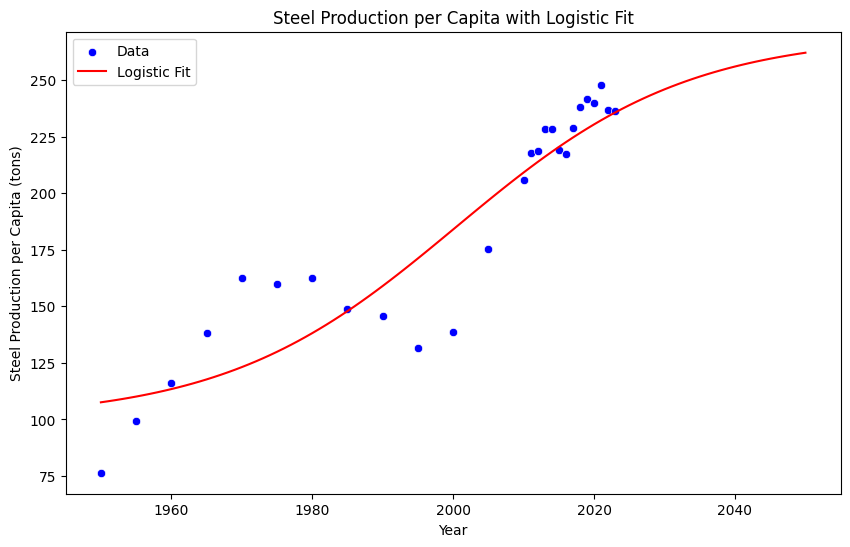

In [43]:
# Fit the logistic function to the data
p0 = [2000, 10, 0, 200]

popt, pcov = curve_fit(
    logistic,
    x_data,
    y_data,
    p0=p0,
    bounds=([1950, 1, 0, 0], [2050, 50, 100, 270]),
    maxfev=10000
)

# Extract fitted parameters
ti_fit, tau_fit, C0_fit, C1_fit = popt

# Predict values using the fitted parameters
extended_years = np.arange(1950, 2051)
pred_logistic = logistic(extended_years, ti_fit, tau_fit, C0_fit, C1_fit)

# Ensure predictions stay positive
pred_logistic = np.maximum(pred_logistic, 0)

print(f"Logistic fit parameters: ti={ti_fit}, tau={tau_fit}, C0={C0_fit}, C1={C1_fit}")

# Plot the data and the fit
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_data, y=y_data, label="Data", color="blue")
sns.lineplot(x=extended_years, y=pred_logistic, label="Logistic Fit", color="red")
plt.title("Steel Production per Capita with Logistic Fit")
plt.xlabel("Year")
plt.ylabel("Steel Production per Capita (tons)")
plt.legend()
plt.show()

Save complete data for steel per capita

In [41]:
# Store data from 1950 to 2050 in a dataframe
steel_projection = pd.DataFrame({
    "Year": extended_years,
    "Steel per capita": logistic(extended_years, ti_fit, tau_fit, C0_fit, C1_fit)
})

# Save complete data for steel per capita as new column in original dataframe
steel_data["Steel per capita"] = steel_projection["Steel per capita"]

# Save dataframe back to original excel file in the original path
steel_data.to_excel(Path.cwd().parent / "data" / "raw" / "steel" / "steel_demand.xlsx", index=False)